In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse

# 1. Import dataset 

In [ ]:
dataset = pd.read_csv('uniqlo_stock_trainset.csv')
dataset.head(3)

,Date,Open,High,Low,Close,Volume,Stock Trading
0,12/30/2016,42120,42330,41700,41830,610000,2.562803e+10
1,12/29/2016,43000,43220,42540,42660,448400,1.918823e+10
2,12/28/2016,43940,43970,43270,43270,339900,1.478067e+10


In [ ]:
description = dataset.describe()
description

,Open,High,Low,Close,Volume,Stock Trading
count,1226.000000,1226.000000,1226.000000,1226.000000,1.226000e+03,1.226000e+03
mean,33754.416803,34178.784666,33347.903752,33760.583197,7.275556e+05,2.440933e+10
std,10813.440409,10936.326802,10695.664102,10815.661389,4.137178e+05,1.526300e+10
min,13720.000000,13840.000000,13600.000000,13720.000000,1.391000e+05,3.966140e+09
25%,27788.750000,28091.250000,27401.250000,27675.000000,4.873000e+05,1.454097e+10
50%,34445.000000,34835.000000,33925.000000,34412.500000,6.260000e+05,2.153772e+10
75%,41412.500000,41900.000000,40810.000000,41365.000000,8.267000e+05,3.015922e+10
max,61550.000000,61970.000000,60740.000000,61930.000000,4.937300e+06,1.460450e+11


change Date column to right format

In [ ]:
import datetime

In [ ]:
# input_format = '%m/%d/%Y' # input format
# date_format = '%d/%m/%Y'
# dataset.Date = [datetime.datetime.strptime(d, input_format).strftime(date_format) for d in dataset.Date]
dataset.Date = pd.to_datetime( dataset.Date ) 

sort the dataset increasing by date -> the lastest value will locate at the end

In [ ]:
dataset = dataset.sort_values(by='Date').reset_index(drop=True)

In [ ]:
dataset.head(5)

,Date,Open,High,Low,Close,Volume,Stock Trading
0,2012-01-04,14050,14050,13700,13720,559100,7.719804e+09
1,2012-01-05,13720,13840,13600,13800,511500,7.030811e+09
2,2012-01-06,13990,14030,13790,13850,765500,1.063561e+10
3,2012-01-10,13890,14390,13860,14390,952300,1.353341e+10
4,2012-01-11,14360,14750,14280,14590,1043400,1.519199e+10


In [ ]:
max_open = description.Open[-1]
dataset.dtypes

Date             datetime64[ns]
Open                      int64
High                      int64
Low                       int64
Close                     int64
Volume                    int64
Stock Trading           float64
dtype: object

In [ ]:
import matplotlib.dates as mdates

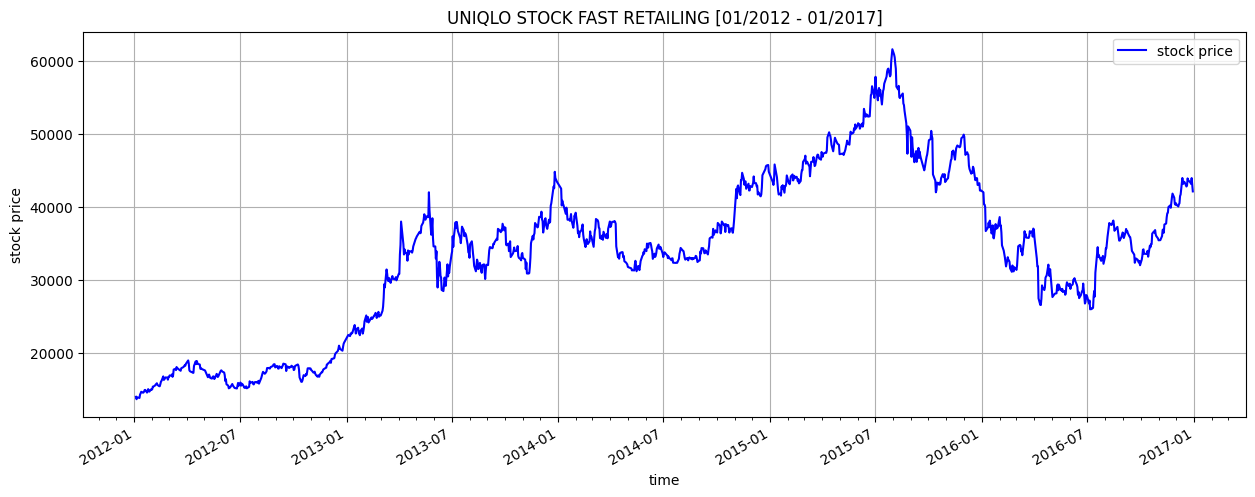

In [ ]:
fig, ax = plt.subplots(figsize=[15,5])
# training accuracy
ax.set_title("UNIQLO STOCK FAST RETAILING [01/2012 - 01/2017]")
ax.plot(dataset.Date, dataset.Open, c='blue',label = "stock price")
ax.set_xlabel('time')
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

ax.set_ylabel('stock price')
ax.grid(True)
ax.legend()

# 2. Normalization

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(dataset.iloc[:,1:].values)  # do not include Date column

In [ ]:
data_shape = data_scaled.shape
print(data_scaled[:5])
print("shape", data_shape)

[[0.00689944 0.00436318 0.00212134 0.         0.08753282 0.02641958]
 [0.         0.         0.         0.00165941 0.07761244 0.02157021]
 [0.00564499 0.00394764 0.00403055 0.00269654 0.13054896 0.04694202]
 [0.00355425 0.01142738 0.00551549 0.01389753 0.16948022 0.06733777]
 [0.01338072 0.01890713 0.01442512 0.01804605 0.18846651 0.07901139]]
shape (1226, 6)


# 3. Train test split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = []
y = []
dates = []
n_step = 100 # predict
for i in range(n_step, data_shape[0]): # choose only ''OPEN''feature
    X.append(data_scaled[i-n_step:i, 0])
    y.append(data_scaled[i, 0])
    dates.append(dataset.Date[i])
X, y = np.array(X), np.array(y)

print(X.shape)
print(y.shape)

(1126, 100)
(1126,)


In [ ]:
split_rate = 0.9  # first 90% of time interval is used for training
split_size = (int)(X.shape[0] * split_rate)
X_train,  X_test = X[:split_size,:], X[split_size:,:]
y_train, y_test = y[:split_size], y[split_size:]
train_date, test_date = dates[:split_size], dates[split_size:]
print("train shape", X_train.shape)
print("test shape", X_test.shape)

train shape (1013, 100)
test shape (113, 100)


In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)

(1013, 100, 1)


In [ ]:
# input: the scaled value (predictions of model), an original max value of the scaled value
# output: origin state of the scaled value 
def restore_ground_val(scaled_p, origin_max):
    return np.array([p*origin_max for p in scaled_p])

# 4. RNN


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout, BatchNormalization

## 4.1. Modeling

In [ ]:
no_unit = 100
# Modeling
start = datetime.datetime.now()
RNN = Sequential(layers=
    [   
        SimpleRNN(units=no_unit, return_sequences=True, input_shape = (X_train.shape[1], 1)),
        SimpleRNN(units=no_unit, return_sequences=True),        
        SimpleRNN(units=no_unit, return_sequences=False),
        Dense(units = 1)        
    ]
)

# Compiling
RNN.compile(optimizer='adam', loss = 'mse', metrics=["mae"])
# RNN.summary()

In [ ]:
# Fitting train data
no_epoch = 10
batch_size = 32
validation_split = 0.2

history_rnn = RNN.fit(X_train, y_train, validation_split=validation_split, epochs = no_epoch, batch_size = batch_size, verbose=0)
end = datetime.datetime.now()
RNN_training_time =  end-start
print("Total execution time: ", RNN_training_time)

Total execution time:  0:00:18.472887


## 4.2. Training progress

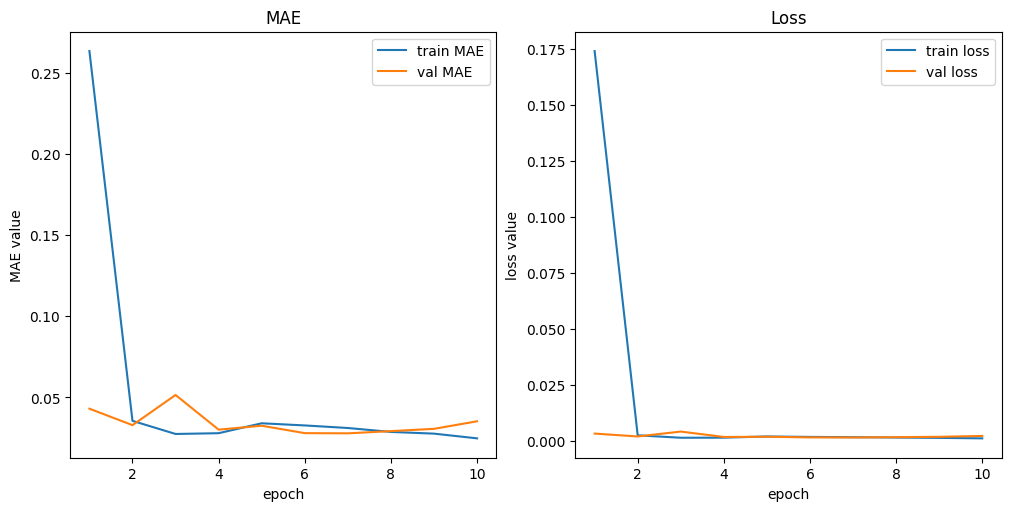

In [ ]:
fig1, ax1 = plt.subplots(figsize=[10,5], nrows=1, ncols=2, layout='constrained')
x_axis = range(1, no_epoch+1)

# training accuracy
ax1[0].set_title("MAE")
ax1[0].plot(x_axis, history_rnn.history['mae'], label = "train MAE")
ax1[0].plot(x_axis, history_rnn.history['val_mae'], label = "val MAE")
ax1[0].set_xlabel('epoch')
ax1[0].set_ylabel('MAE value')
ax1[0].legend()

# training loss
ax1[1].set_title("Loss")
ax1[1].plot(x_axis,history_rnn.history['loss'], label = "train loss")
ax1[1].plot(x_axis,history_rnn.history['val_loss'], label = "val loss")
ax1[1].set_xlabel('epoch')
ax1[1].set_ylabel('loss value')
ax1[1].legend()

## 4.3. RNN Prediction 

In [ ]:
start = datetime.datetime.now()
y_pred_rnn = RNN.predict(X_test)
y_pred_rnn = restore_ground_val(y_pred_rnn, max_open)
y_true =  restore_ground_val(y_test, max_open)
print(y_pred_rnn.shape)
end = datetime.datetime.now()
RNN_test_time =  end-start
print("Total test time: ", RNN_test_time)

4/4 [==============================] - 0s 19ms/step
(113, 1)
Total test time:  0:00:00.488424


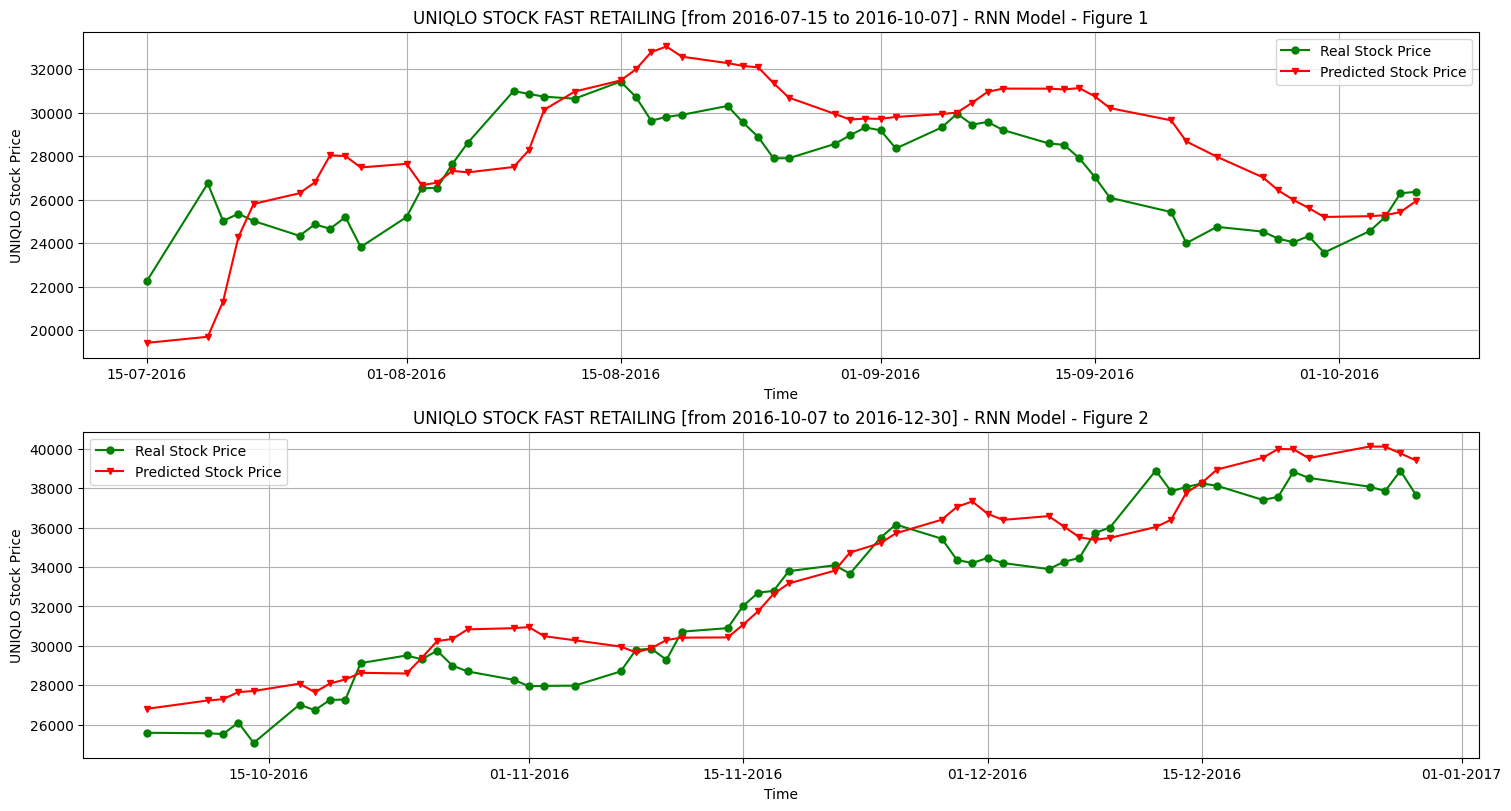

In [ ]:
fig_num = 2
fig, ax = plt.subplots(figsize=[15,4*fig_num], nrows=fig_num, ncols=1, layout='constrained')
test_len = y_pred_rnn.shape[0]

for i in range(fig_num):
    start = (test_len // fig_num) * i
    end = (test_len // fig_num) * (i+1) if i != fig_num-1 else test_len -1
    ax[i].set_title(f'UNIQLO STOCK FAST RETAILING [from {test_date[start].date()} to {test_date[end].date()}] - RNN Model - Figure {i+1}')
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
    ax[i].plot(test_date[start:end], y_true[start:end], color = 'green', marker='o', markersize=5, label = "Real Stock Price")
    ax[i].plot(test_date[start:end], y_pred_rnn[start:end], color = 'red', marker='v', markersize=5, label = "Predicted Stock Price")
    ax[i].legend()
    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('UNIQLO Stock Price')
    ax[i].grid(True)
fig.savefig('RNN prediction')

## 4.4. RNN Forecasting

### 4.4.1. Next 2 weeks forecasting

In [ ]:
def forecast_next2week_RNN(
        model, 
        init_data: np.array, 
        no_prev_day: int,
        time_stamp,
        model_name: str
    ):
    '''
    input:
        model: the deep learning model that gonna be used
        init_data: data of the previous days to initilize the forecasting sequence
        no_prev_day: the number of the day which the model's prediction take base on 
            this param is the len of each input that you train your model
        model name: the name of algorithm 
    output:
        forecasting values of next 7 days
        visualization
    '''

    if len(init_data) < no_prev_day: # if the init data is too short to be based on
        return

    # prepare 
    prev_days = init_data[-no_prev_day:]
    prev_days = prev_days.reshape(-1, 1)
    prev_days = np.expand_dims(prev_days, axis=0)
    forecast_v = np.array([])

    # forecasting
    for i in range (14):
        prediction = model.predict(prev_days, verbose=0)
        forecast_v = np.append(forecast_v, prediction)
        prev_days = np.append(init_data, forecast_v)[-no_prev_day:].reshape(-1, 1)
        prev_days = np.expand_dims(prev_days, axis=0)

    # restore to integer value
    # def restore(prd, org): # second ver of `restore_ground_val`
        
    #     pass
    forecast_v = restore_ground_val(forecast_v, max_open)
    weeks_before = restore_ground_val(init_data[-no_prev_day:], max_open)

    # visualize ============================================
    fig, ax = plt.subplots(figsize=[10, 6], nrows=2, ncols=1, layout="constrained")

    # ====================== this psuedo-week =========================================
    ax[0].set_title(f'UNIQLO STOCK PRICE {no_prev_day} DAYS BEFORE')
    ax[0].plot(time_stamp, weeks_before, marker='v', markersize=5, label = "Last days price")
    ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
    ax[0].grid(True)
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('UNIQLO Stock Price')
    ax[0].legend()
    

    # ======================== next week ===============================================
    next_week = [time_stamp[-1] + datetime.timedelta(1)]
    for i in range(13):
        next_week += [next_week[-1] + datetime.timedelta(1)]
    
    ax[1].set_title(f'UNIQLO STOCK PRICE NEXT 2 WEEKS FORECASTING - {model_name} Model')
    ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
    ax[1].plot(next_week, forecast_v, color = 'red', marker='o', markersize=5, label = "Forecasting price")
    ax[1].grid(True)
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('UNIQLO Stock Price')
    ax[1].legend()
    for label in ax[1].get_xticklabels(which='major'):
        label.set(rotation=30, horizontalalignment='right')


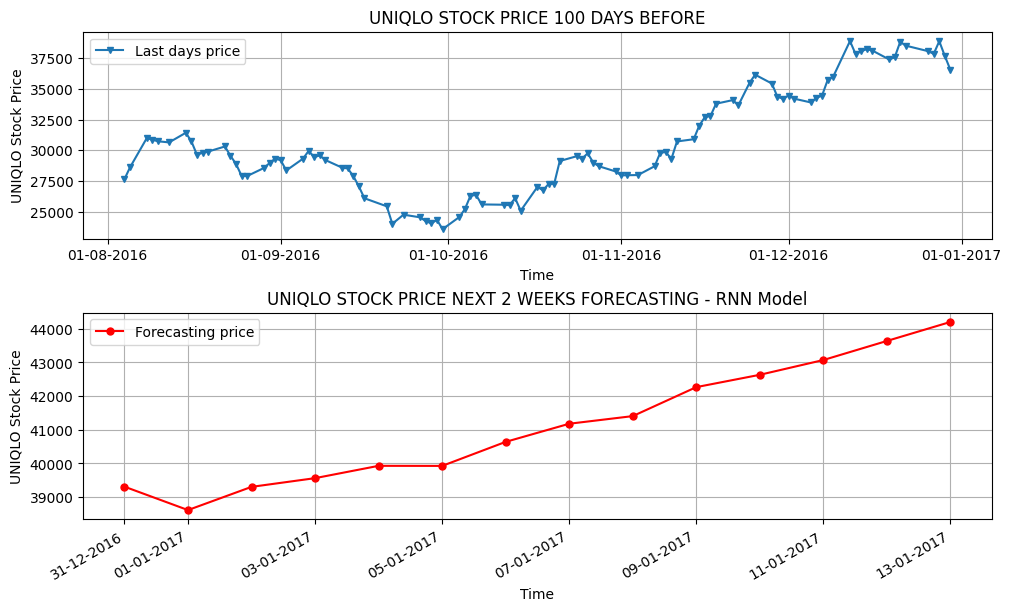

In [ ]:
latest_days = dates[-n_step:]
forecast_next2week_RNN(model=RNN, init_data=y, no_prev_day=n_step, model_name="RNN", time_stamp=latest_days)

### 4.4.2. Next 7 weeks forecasting

In [ ]:
def forecast_7weeks_RNN(
        model, 
        init_data: np.array, 
        no_prev_day: int,
        time_stamp,
        model_name: str
    ):
    '''
    input:
        model: the deep learning model that gonna be used
        init_data: data of the previous days to initilize the forecasting sequence
        no_prev_day: the number of the day which the model's prediction take base on 
            this param is the len of each input that you train your model
        model name: the name of algorithm 
    output:
        forecasting values of next 7 weeks
        visualization
    '''
    if len(init_data) < no_prev_day: # if the init data is too short to be based on
        return

    # prepare 
    prev_days = init_data[-no_prev_day:]
    prev_days = prev_days.reshape(-1, 1)
    prev_days = np.expand_dims(prev_days, axis=0)
    forecast_v = np.array([])

    # forecasting
    for i in range (49):
        prediction = model.predict(prev_days, verbose=0)
        forecast_v = np.append(forecast_v, prediction)
        prev_days = np.append(init_data, forecast_v)[-no_prev_day:].reshape(-1, 1)
        prev_days = np.expand_dims(prev_days, axis=0)

    # restore to integer value
    # def restore(prd, org): # second ver of `restore_ground_val`
        
    #     pass
    forecast_v = restore_ground_val(forecast_v, max_open)
    weeks_before = restore_ground_val(init_data[-no_prev_day:], max_open)

    # visualize ============================================
    fig, ax = plt.subplots(figsize=[10, 6], nrows=2, ncols=1, layout="constrained")

    # ====================== last days =========================================
    ax[0].set_title(f'UNIQLO STOCK PRICE {no_prev_day} DAYS BEFORE')
    ax[0].plot(time_stamp, weeks_before, marker='v', markersize=5, label = "Last days price")
    ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
    ax[0].grid(True)
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('UNIQLO Stock Price')
    ax[0].legend()
    for label in ax[0].get_xticklabels(which='major'):
        label.set(rotation=30, horizontalalignment='right')

    # ======================== next week ===============================================
    next_7week = [time_stamp[-1] + datetime.timedelta(1)]
    for i in range(48):
        next_7week += [next_7week[-1] + datetime.timedelta(1)]
    line_color = ['red', 'orange', 'brown', 'green', 'blue', 'magenta', "black"]
    chars = ["o", "v", "*", "x", "s", "+", "D"]
    ax[1].set_title(f'UNIQLO STOCK PRICE NEXT 7 WEEKS FORECASTING - {model_name} Model')
    ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
    ax[1].plot(next_7week, forecast_v, color = 'red', marker='o', markersize=5, label = "Forecasting price")
    ax[1].grid(True)
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('UNIQLO Stock Price')
    ax[1].legend()

    # =========================================== 1 single fig for 7 weeks ======    
    start, end = 0, 7
    fig = plt.figure(figsize=[10, 3], layout="constrained")
    for i in range(7):
        plt.title(f'UNIQLO STOCK PRICE NEXT 7 WEEKS FORECASTING - {model_name} Model')
        plt.plot(next_7week[start: end], forecast_v[start: end],color = line_color[i], marker=chars[i], markersize=4, label = f"week {i+1}")
        plt.grid(True)
        plt.xlabel('Time')
        plt.ylabel('UNIQLO Stock Price')
        plt.legend()
        start +=7
        end += 7
        
    # =========================================== 7 figs ==============    
    start, end = 0, 7
    for i in range(7):
        fig1 = plt.figure(figsize=[5, 3], layout="constrained")
        plt.title(f'UNIQLO STOCK PRICE FORECASTING WEEK [{i+1}/7] - {model_name} Model')
        plt.plot(next_7week[start: end], forecast_v[start: end],color = line_color[i], marker=chars[i], markersize=4, label = f"week {i+1}")
        plt.grid(True)
        plt.xlabel('Time')
        plt.xticks(fontsize=7, rotation=20)
        plt.ylabel('UNIQLO Stock Price')
        plt.legend()
        start +=7
        end += 7

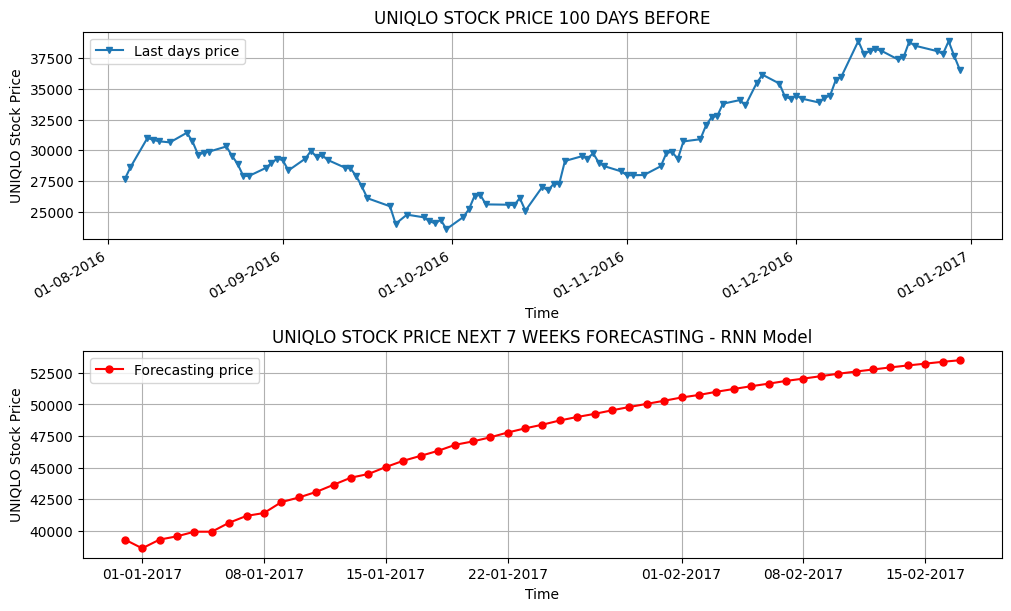

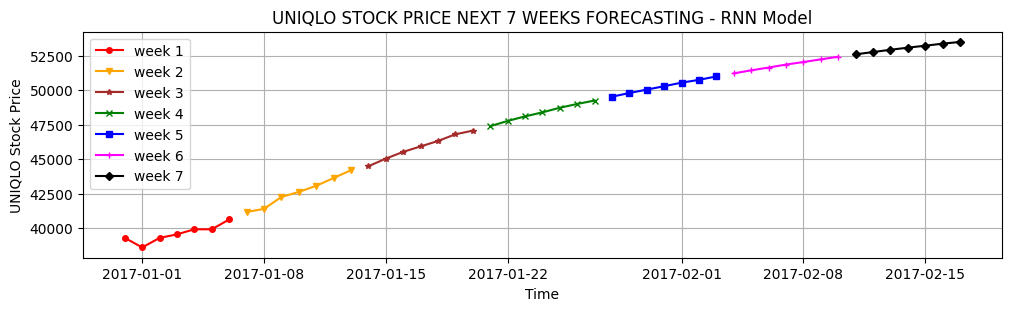

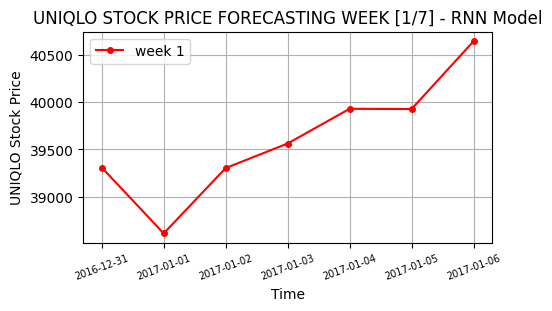

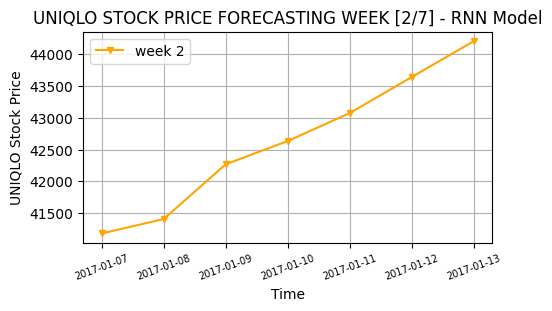

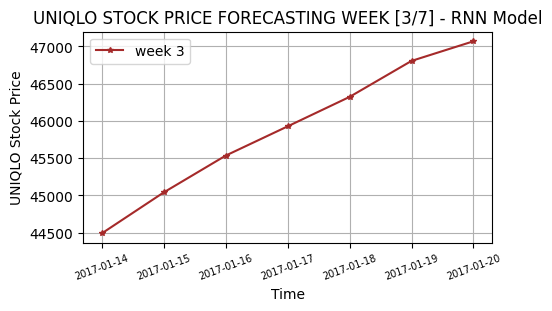

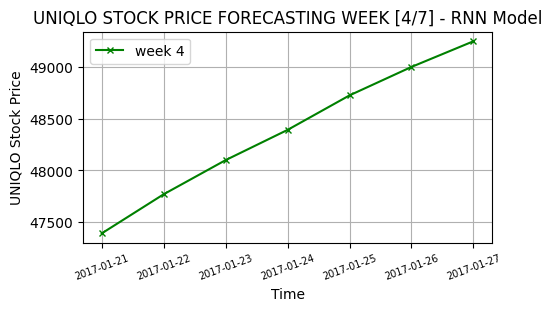

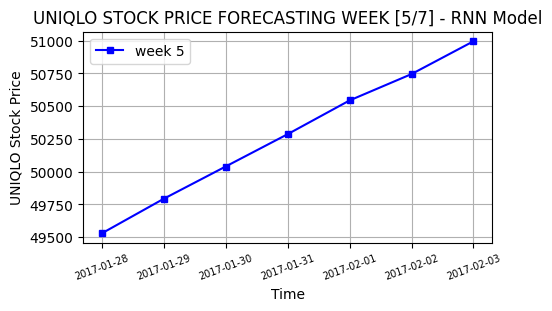

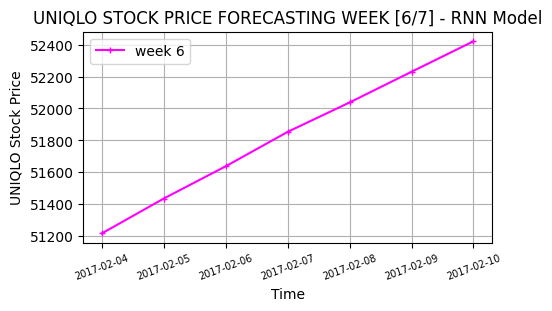

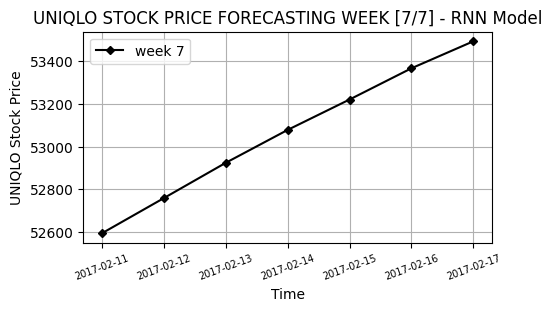

In [ ]:
forecast_7weeks_RNN(model=RNN, init_data=y, no_prev_day=n_step, model_name="RNN", time_stamp=latest_days)

# 5. MLP

## 5.1. Modeling

In [ ]:
start = datetime.datetime.now()
MLP = Sequential(layers=
    [   
        Dense(units=128, activation='relu', input_dim = n_step),
            BatchNormalization(),
        Dense(units=64, activation='relu'),
            BatchNormalization(),        
        Dense(units=32, activation='relu'),
            BatchNormalization(),     
            Dropout(rate=0.3),
        Dense(units = 1)        
    ]
)

# Compiling
MLP.compile(optimizer='adam', loss = 'mse', metrics=["mae"])

In [ ]:
# Fitting train data
no_epoch = 100
batch_size = 32
validation_split = 0.2

history_mlp = MLP.fit(x=X_train,y=y_train, 
    validation_split=validation_split, 
    epochs = no_epoch, 
    batch_size = batch_size,
    verbose = 0
)
end = datetime.datetime.now()
MLP_training_time =  end-start
print("Total execution time: ", MLP_training_time)

Total execution time:  0:00:13.317771


In [ ]:
MLP.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 128)               12928     
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_2 (Batc  (None, 32)              

## 5.2. Training Progress

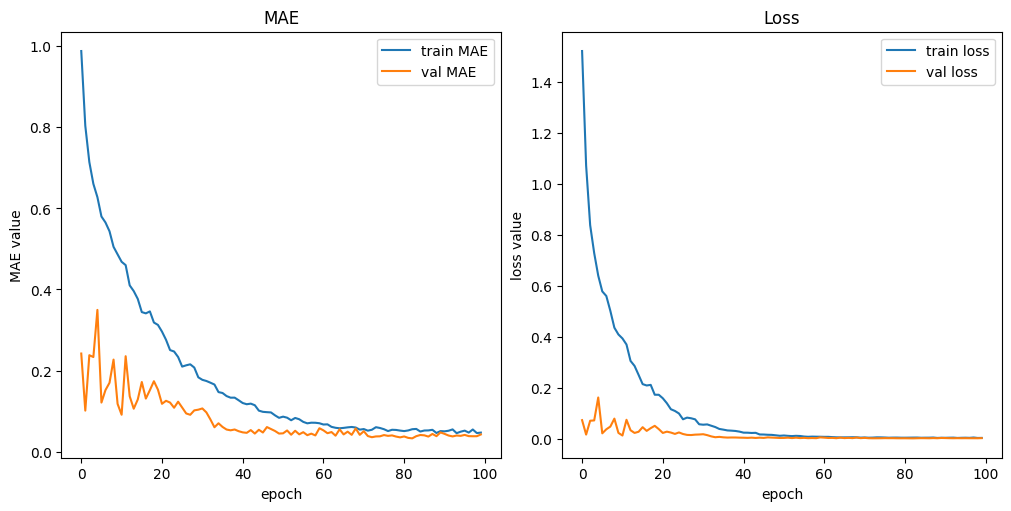

In [ ]:
fig2, ax2 = plt.subplots(figsize=[10,5], nrows=1, ncols=2, layout='constrained')
# training accuracy
ax2[0].set_title("MAE")
ax2[0].plot(history_mlp.history['mae'], label = "train MAE")
ax2[0].plot(history_mlp.history['val_mae'], label = "val MAE")
ax2[0].set_xlabel('epoch')
ax2[0].set_ylabel('MAE value')
ax2[0].legend()

# training loss
ax2[1].set_title("Loss")
ax2[1].plot(history_mlp.history['loss'], label = "train loss")
ax2[1].plot(history_mlp.history['val_loss'], label = "val loss")
ax2[1].set_xlabel('epoch')
ax2[1].set_ylabel('loss value')
ax2[1].legend()

## 5.3. MLP Prediction

In [ ]:
start = datetime.datetime.now()
y_pred_mlp = MLP.predict(X_test)
y_pred_mlp = restore_ground_val(y_pred_mlp, max_open)
y_true = restore_ground_val(y_test, max_open)
print(y_pred_mlp.shape)
end = datetime.datetime.now()
MLP_test_time =  end-start
print("Total test time: ", MLP_test_time)

4/4 [==============================] - 0s 1ms/step
(113, 1)
Total test time:  0:00:00.173289


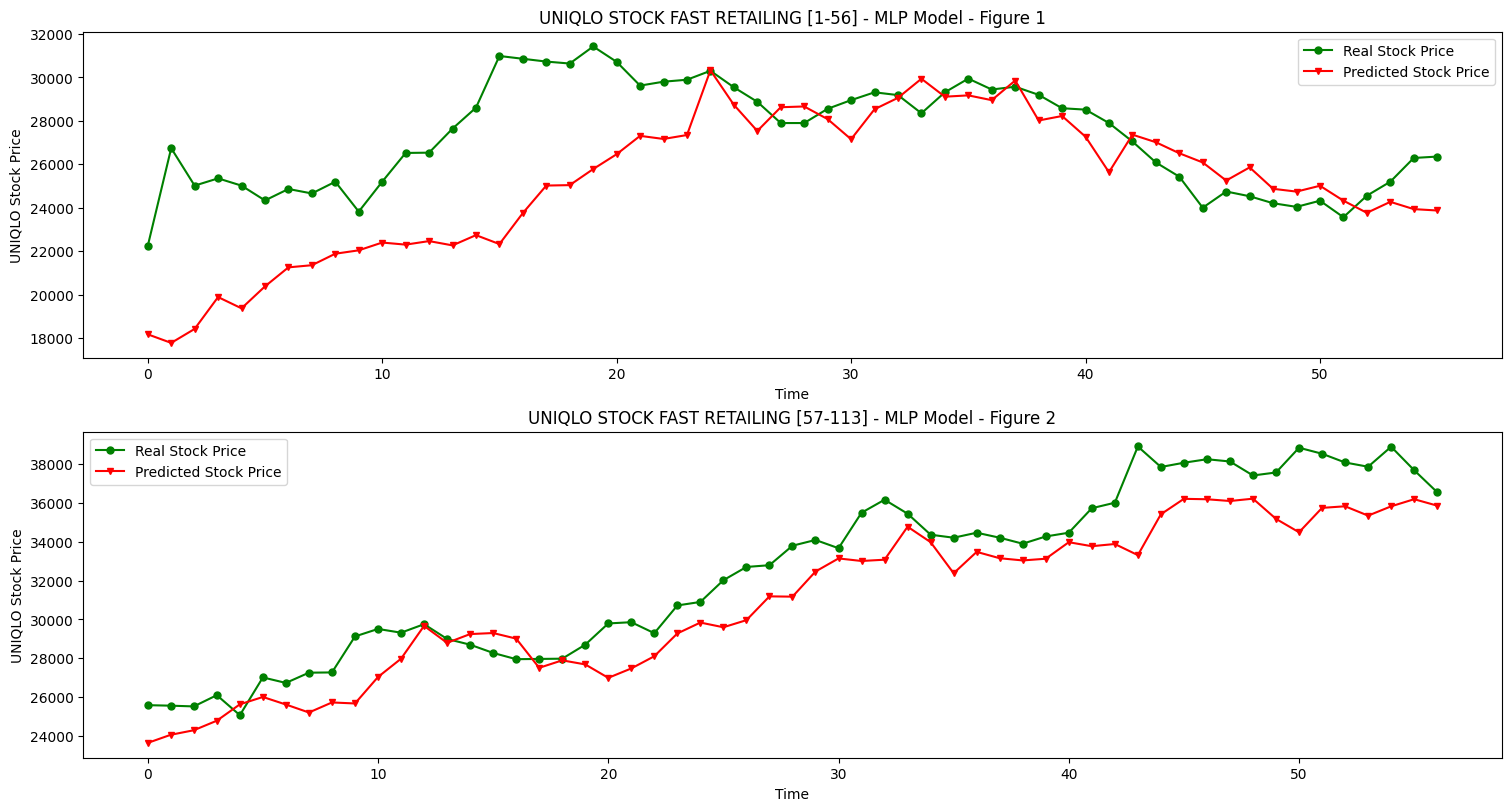

In [ ]:
fig_num = 2
fig, ax = plt.subplots(figsize=[15,4*fig_num], nrows=fig_num, ncols=1, layout='constrained')
test_len = y_pred_mlp.shape[0]

for i in range(fig_num):
    start = (test_len // fig_num) * i
    end = (test_len // fig_num) * (i+1) if i != fig_num-1 else test_len
    ax[i].set_title(f'UNIQLO STOCK FAST RETAILING [{start+1}-{end}] - MLP Model - Figure {i+1}')
    ax[i].plot(y_true[start:end], color = 'green', marker='o', markersize=5, label = "Real Stock Price")
    ax[i].plot(y_pred_mlp[start:end], color = 'red', marker='v', markersize=5, label = "Predicted Stock Price")
    ax[i].legend()
    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('UNIQLO Stock Price')
fig.savefig('MLP prediction')


## 5.4. MLP Forecasting

## 5.4.1. next 2 weeks 

In [ ]:
def forecast_next2week_MLP(
        model, 
        init_data: np.array, 
        no_prev_day: int,
        time_stamp,
        model_name: str
    ):
    '''
    input:
        model: the deep learning model that gonna be used
        init_data: data of the previous days to initilize the forecasting sequence
        no_prev_day: the number of the day which the model's prediction take base on 
            this param is the len of each input that you train your model
        model name: the name of algorithm 
    output:
        forecasting values of next 7 days
        visualization
    '''

    if len(init_data) < no_prev_day: # if the init data is too short to be based on
        return

    # prepare 
    prev_days = init_data[-no_prev_day:]
    # prev_days = prev_days.reshape(-1, 1)
    prev_days = np.expand_dims(prev_days, axis=0)
    forecast_v = np.array([])
    print(prev_days.shape)
    # forecasting
    for i in range(14):
        prediction = model.predict(prev_days, verbose=0)
        forecast_v = np.append(forecast_v, prediction)
        prev_days = np.append(init_data, forecast_v)[-no_prev_day:]
        prev_days = np.expand_dims(prev_days, axis=0)

    # restore to integer value
    # def restore(prd, org): # second ver of `restore_ground_val`
        
    #     pass
    forecast_v = restore_ground_val(forecast_v, max_open)
    weeks_before = restore_ground_val(init_data[-no_prev_day:], max_open)

    # visualize ============================================
    fig, ax = plt.subplots(figsize=[10, 6], nrows=2, ncols=1, layout="constrained")

    # ====================== this psuedo-week =========================================
    ax[0].set_title(f'UNIQLO STOCK PRICE {no_prev_day} DAYS BEFORE')
    ax[0].plot(time_stamp, weeks_before, marker='v', markersize=5, label = "Last days price")
    ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
    ax[0].grid(True)
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('UNIQLO Stock Price')
    ax[0].legend()
    

    # ======================== next week ===============================================
    next_week = [time_stamp[-1] + datetime.timedelta(1)]
    for i in range(13):
        next_week += [next_week[-1] + datetime.timedelta(1)]
    
    ax[1].set_title(f'UNIQLO STOCK PRICE NEXT 2 WEEKS FORECASTING - {model_name} Model')
    ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
    ax[1].plot(next_week, forecast_v, color = 'red', marker='o', markersize=5, label = "Forecasting price")
    ax[1].grid(True)
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('UNIQLO Stock Price')
    ax[1].legend()
    for label in ax[1].get_xticklabels(which='major'):
        label.set(rotation=30, horizontalalignment='right')


(1, 100)


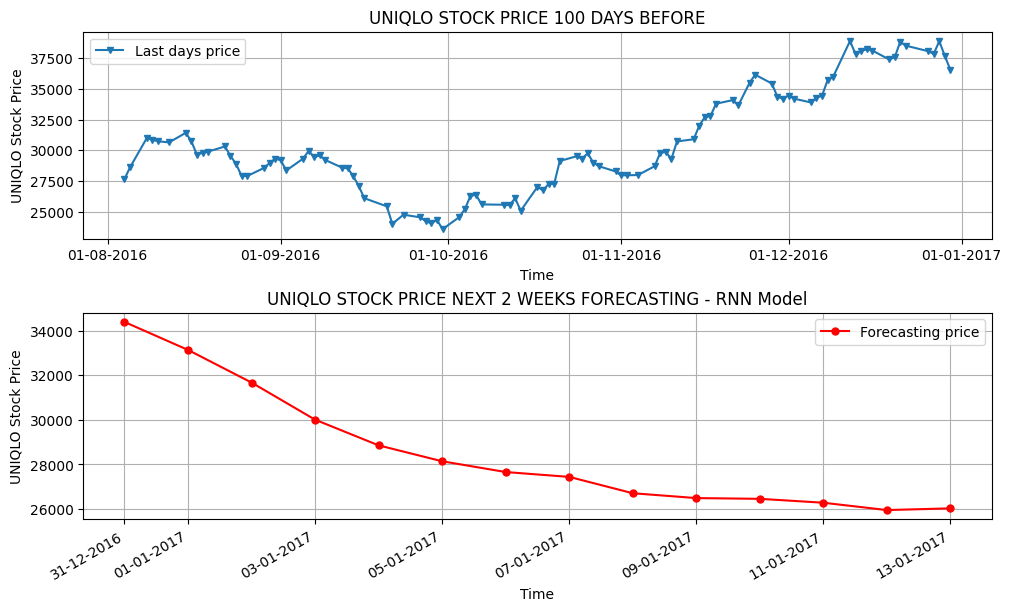

In [ ]:
latest_days = dates[-n_step:]
forecast_next2week_MLP(model=MLP, init_data=y, no_prev_day=n_step, model_name="RNN", time_stamp=latest_days)

## 5.4.2. next 7 weeks

In [ ]:
def forecast_7weeks_MLP(
        model, 
        init_data: np.array, 
        no_prev_day: int,
        time_stamp,
        model_name: str
    ):
    '''
    input:
        model: the deep learning model that gonna be used
        init_data: data of the previous days to initilize the forecasting sequence
        no_prev_day: the number of the day which the model's prediction take base on 
            this param is the len of each input that you train your model
        model name: the name of algorithm 
    output:
        forecasting values of next 7 weeks
        visualization
    '''
    if len(init_data) < no_prev_day: # if the init data is too short to be based on
        return

    # prepare 
    prev_days = init_data[-no_prev_day:]
    prev_days = np.expand_dims(prev_days, axis=0)
    forecast_v = np.array([])

    # forecasting
    for i in range (49):
        prediction = model.predict(prev_days, verbose=0)
        forecast_v = np.append(forecast_v, prediction)
        prev_days = np.append(init_data, forecast_v)[-no_prev_day:]
        prev_days = np.expand_dims(prev_days, axis=0)

    # restore to integer value
    # def restore(prd, org): # second ver of `restore_ground_val`
        
    #     pass
    forecast_v = restore_ground_val(forecast_v, max_open)
    weeks_before = restore_ground_val(init_data[-no_prev_day:], max_open)

    # visualize ============================================
    fig, ax = plt.subplots(figsize=[10, 6], nrows=2, ncols=1, layout="constrained")

    # ====================== last days =========================================
    ax[0].set_title(f'UNIQLO STOCK PRICE {no_prev_day} DAYS BEFORE')
    ax[0].plot(time_stamp, weeks_before, marker='v', markersize=5, label = "Last days price")
    ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
    ax[0].grid(True)
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('UNIQLO Stock Price')
    ax[0].legend()
    for label in ax[0].get_xticklabels(which='major'):
        label.set(rotation=30, horizontalalignment='right')

    # ======================== next week ===============================================
    next_7week = [time_stamp[-1] + datetime.timedelta(1)]
    for i in range(48):
        next_7week += [next_7week[-1] + datetime.timedelta(1)]
    line_color = ['red', 'orange', 'brown', 'green', 'blue', 'magenta', "black"]
    chars = ["o", "v", "*", "x", "s", "+", "D"]
    ax[1].set_title(f'UNIQLO STOCK PRICE NEXT 7 WEEKS FORECASTING - {model_name} Model')
    ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
    ax[1].plot(next_7week, forecast_v, color = 'red', marker='o', markersize=5, label = "Forecasting price")
    ax[1].grid(True)
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('UNIQLO Stock Price')
    ax[1].legend()

    # =========================================== 1 single fig for 7 weeks ======    
    start, end = 0, 7
    fig = plt.figure(figsize=[10, 3], layout="constrained")
    for i in range(7):
        plt.title(f'UNIQLO STOCK PRICE NEXT 7 WEEKS FORECASTING - {model_name} Model')
        plt.plot(next_7week[start: end], forecast_v[start: end],color = line_color[i], marker=chars[i], markersize=4, label = f"week {i+1}")
        plt.grid(True)
        plt.xlabel('Time')
        plt.ylabel('UNIQLO Stock Price')
        plt.legend()
        start +=7
        end += 7
        
    # =========================================== 7 figs ==============    
    start, end = 0, 7
    for i in range(7):
        fig1 = plt.figure(figsize=[5, 3], layout="constrained")
        plt.title(f'UNIQLO STOCK PRICE FORECASTING WEEK [{i+1}/7] - {model_name} Model')
        plt.plot(next_7week[start: end], forecast_v[start: end],color = line_color[i], marker=chars[i], markersize=4, label = f"week {i+1}")
        plt.grid(True)
        plt.xlabel('Time')
        plt.xticks(fontsize=7, rotation=20)
        plt.ylabel('UNIQLO Stock Price')
        plt.legend()
        start +=7
        end += 7

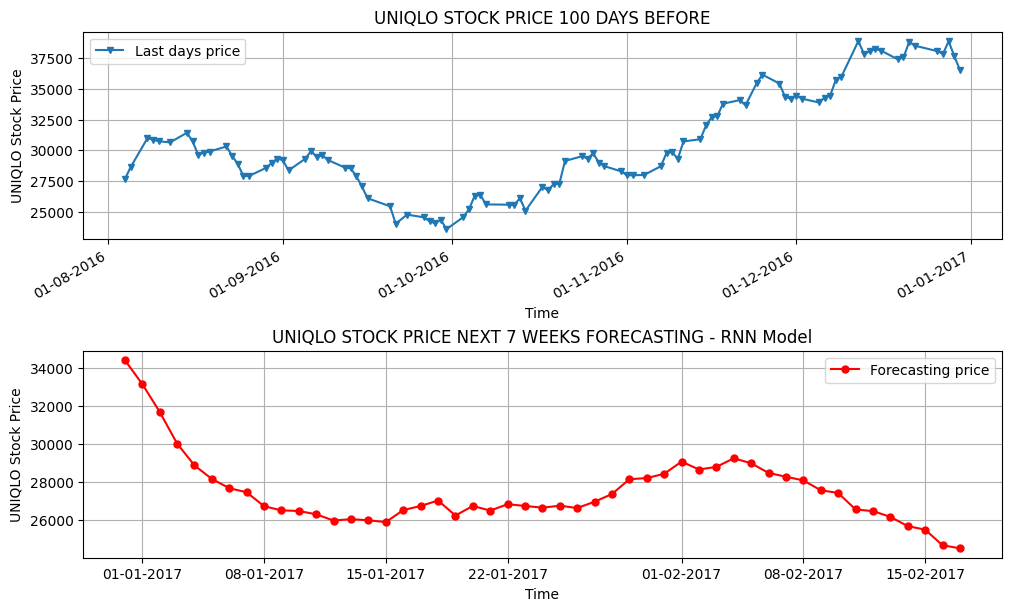

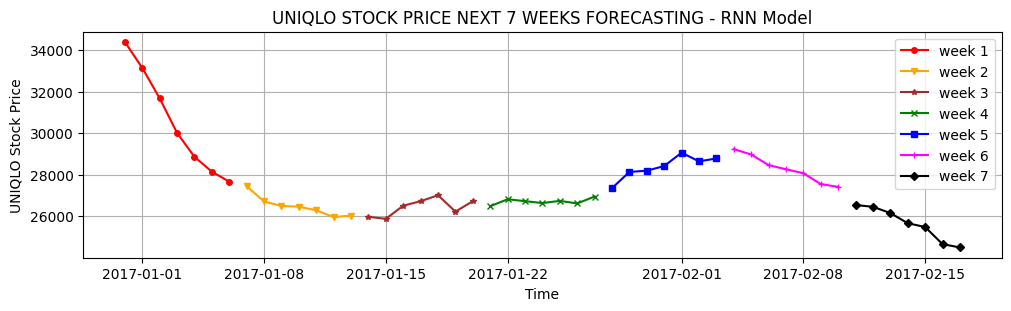

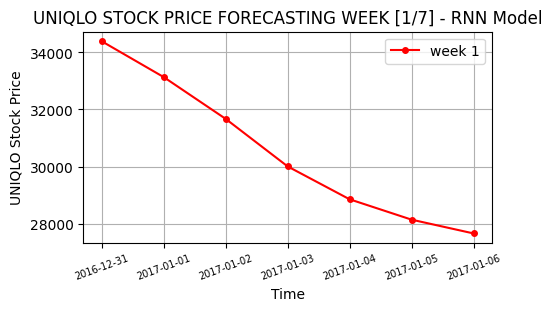

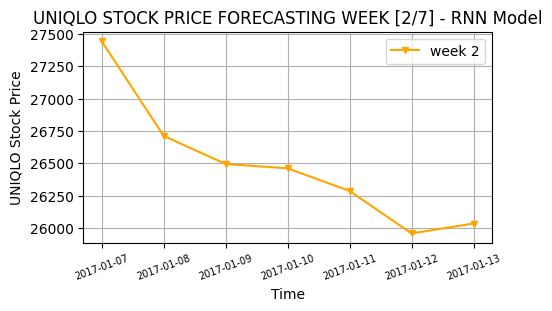

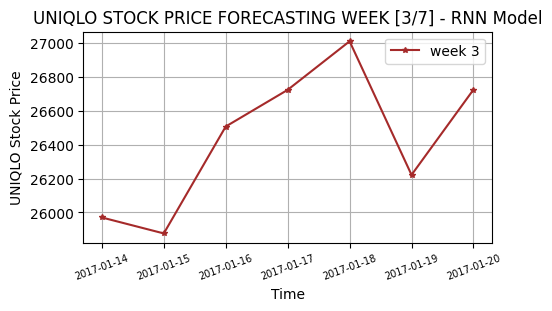

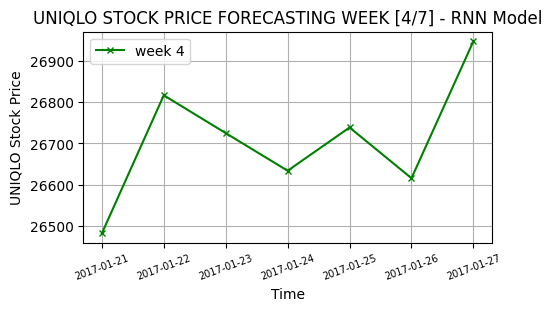

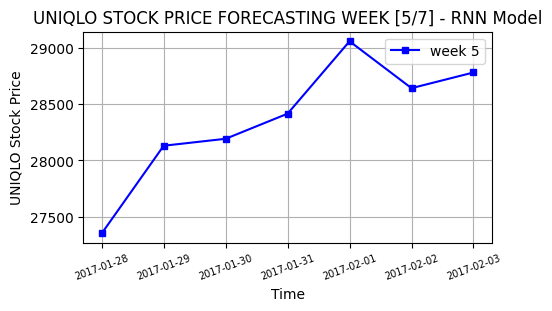

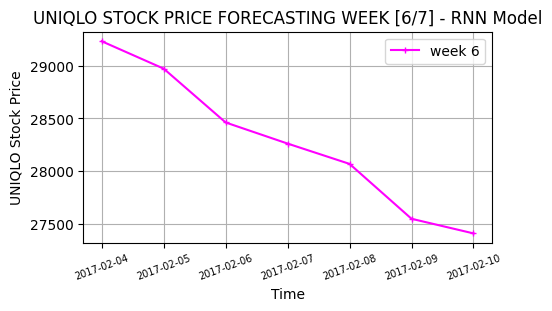

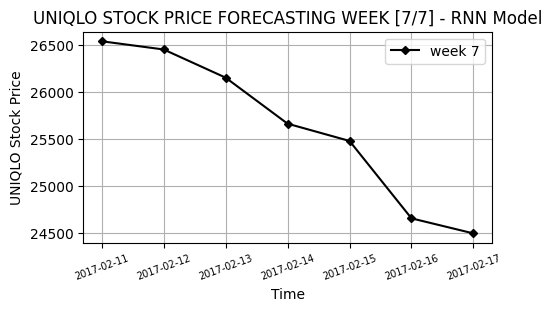

In [ ]:
forecast_7weeks_MLP(model=MLP, init_data=y, no_prev_day=n_step, model_name="RNN", time_stamp=latest_days)

# Comparing training & testing time of 2 models

In [ ]:
train_times = [x.total_seconds() for x in  [RNN_training_time, MLP_training_time]]
test_times = [x.total_seconds() for x in [RNN_test_time,MLP_test_time]]
model_names = [ "RNN", "MLP"]
comparation = pd.DataFrame([train_times, test_times], index=["train", "test"], columns = model_names)

In [ ]:
comparation

,RNN,MLP
train,18.472887,13.317771
test,0.488424,0.173289


Text(0, 0.5, 'time in second')

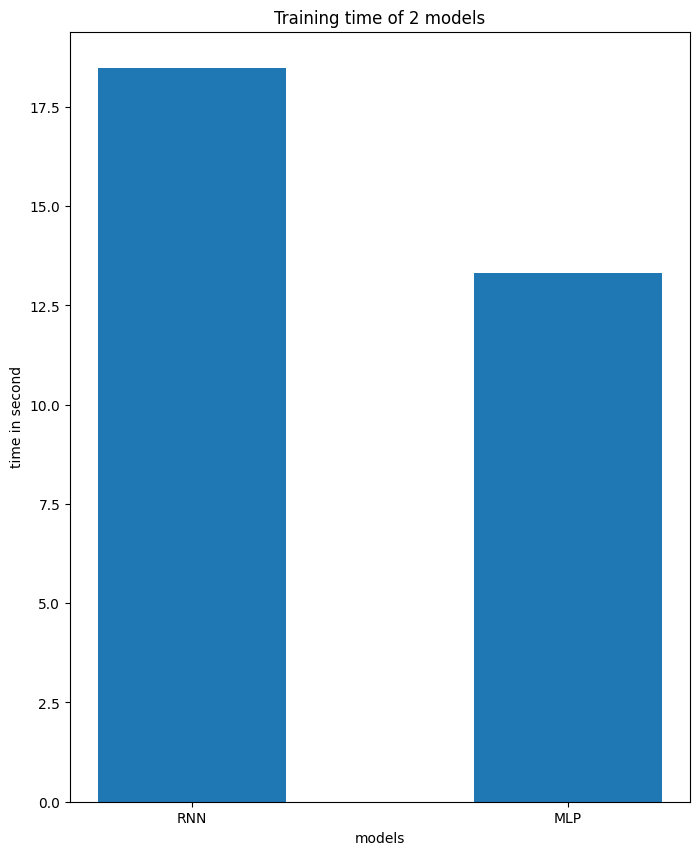

In [ ]:
plt.figure(figsize=[8, 10])
plt.bar(x=model_names, height=train_times, width = 0.5)
plt.title("Training time of 2 models")
plt.xlabel("models")
plt.ylabel("time in second")

Text(0, 0.5, 'time in second')

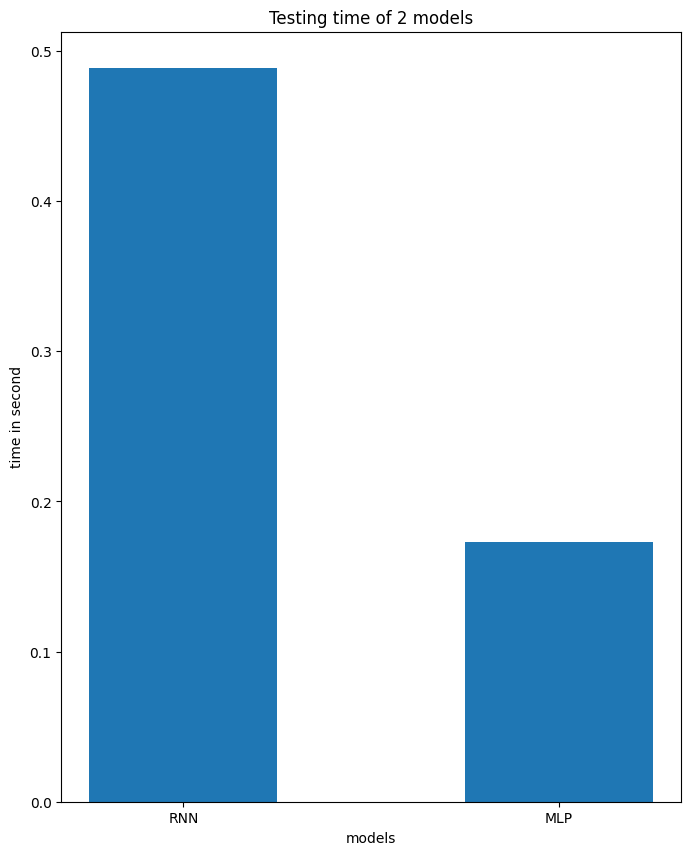

In [ ]:
plt.figure(figsize=[8, 10])
plt.bar(x=model_names, height=test_times, width = 0.5)
plt.title("Testing time of 2 models")
plt.xlabel("models")
plt.ylabel("time in second")

# X. Compare MSE, MAE of 2 models

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


y_preds = [y_pred_rnn, y_pred_mlp]
mse = []
mae = []
for y_pred in y_preds:
    mse += [mean_squared_error(y_pred=y_pred,y_true= y_true, squared=False)]
    mae += [mean_absolute_error(y_pred=y_pred,y_true= y_true)]

Text(37.097222222222214, 0.5, 'MAE and MSE metric')

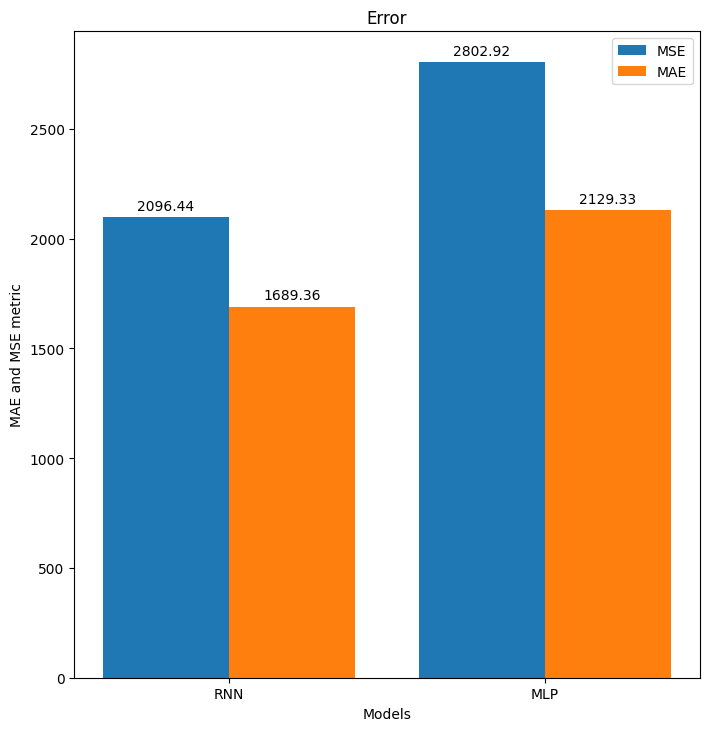

In [ ]:
x = np.arange(2)
width = 0.4

plt.figure(figsize=[7,7])
c1 = plt.bar(x - width/2, mse, width = width, label = "MSE")
c2 = plt.bar(x + width/2, mae, width = width, label = "MAE")

plt.bar_label(c1, padding=3)
plt.bar_label(c2, padding=3)

plt.tight_layout()
plt.xticks(x,["RNN", "MLP"])
plt.legend()
plt.title("Error")
plt.xlabel("Models")
plt.ylabel("MAE and MSE metric")

# 6. LSTM

from keras.layers import LSTM, Bidirectional

## 6.1. Modeling

# Modeling
no_unit = 50
LSTM = Sequential(layers=
    [   
        Bidirectional(layer =       
            LSTM(units=no_unit, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1))
        ),
        Bidirectional(layer = 
            LSTM(units=no_unit, activation='relu', return_sequences=True)
        ),        
        Bidirectional(layer =
            LSTM(units=no_unit, activation='relu', return_sequences=False)
        ),
        Dense(units = 1)        
    ]
)

# Compiling
LSTM.compile(optimizer='adam', loss = 'mse', metrics=["mae"])
# LSTM.summary()

print(X_train.shape)

# Fitting train data
no_epoch = 10
batch_size = 32 
validation_split = 0.2

history_lstm = LSTM.fit(X_train, y_train, validation_split=validation_split, epochs = no_epoch, batch_size = batch_size)

## 6.2. Training Progress

fig3, ax3 = plt.subplots(figsize=[10,5], nrows=1, ncols=2, layout='constrained')
# training accuracy
ax3[0].set_title("MAE")
ax3[0].plot(history_lstm.history['mae'], label = "train MAE")
ax3[0].plot(history_lstm.history['val_mae'], label = "val MAE")
ax3[0].set_xlabel('epoch')
ax3[0].set_ylabel('MAE value')
ax3[0].legend()

# training loss
ax3[1].set_title("Loss")
ax3[1].plot(history_lstm.history['loss'], label = "train loss")
ax3[1].plot(history_lstm.history['val_loss'], label = "val loss")
ax3[1].set_xlabel('epoch')
ax3[1].set_ylabel('loss value')
ax3[1].legend()

## 6.3. LSTM Prediction

y_pred_lstm = LSTM.predict(X_test)
y_pred_lstm = restore_ground_val(y_pred_lstm, max_open)
y_true =  restore_ground_val(y_test, max_open)
print(y_pred_lstm.shape)

fig_num = 2
fig, ax = plt.subplots(figsize=[15,4*fig_num], nrows=fig_num, ncols=1, layout='constrained')
test_len = y_pred_lstm.shape[0]

for i in range(fig_num):
    start = (test_len // fig_num) * i
    end = (test_len // fig_num) * (i+1) if i != fig_num-1 else test_len
    ax[i].set_title(f'UNIQLO STOCK FAST RETAILING [{start+1}-{end}] - RNN Model - Figure {i+1}')
    ax[i].plot(y_true[start:end], color = 'green', marker='o', markersize=5, label = "Real Stock Price")
    ax[i].plot(y_pred_lstm[start:end], color = 'red', marker='v', markersize=5, label = "Predicted Stock Price")
    ax[i].legend()
    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('UNIQLO Stock Price')
fig.savefig('LSTM prediction')

# 7. K-Nearest Regressor

In [ ]:
X_full, y_full = data_scaled[:, 2:], data_scaled[:, 1]
X_train_full,  X_test_full = X_full[:split_size,:], X_full[split_size:,:]
y_train_full, y_test_full = y_full[:split_size], y_full[split_size:]

print("train shape", X_train_full.shape)
print("test shape", X_test_full.shape)

train shape (1013, 4)
test shape (213, 4)


In [ ]:
from sklearn.neighbors import KNeighborsRegressor

## 7.1. Modeling

In [ ]:
KNR = KNeighborsRegressor(n_neighbors=10)
KNR.fit(X_train_full, y_train_full)

KNeighborsRegressor(n_neighbors=10)

## 7.2. KNR Prediction

In [ ]:
y_pred_knr = KNR.predict(X_test_full)
y_pred_knr = restore_ground_val(y_pred_knr, max_open)
y_true = restore_ground_val(y_test_full, max_open)
y_pred_knr.shape

(213,)

In [ ]:
mean_squared_error(y_pred=y_pred_knr, y_true=y_true)

1064449.5990551533

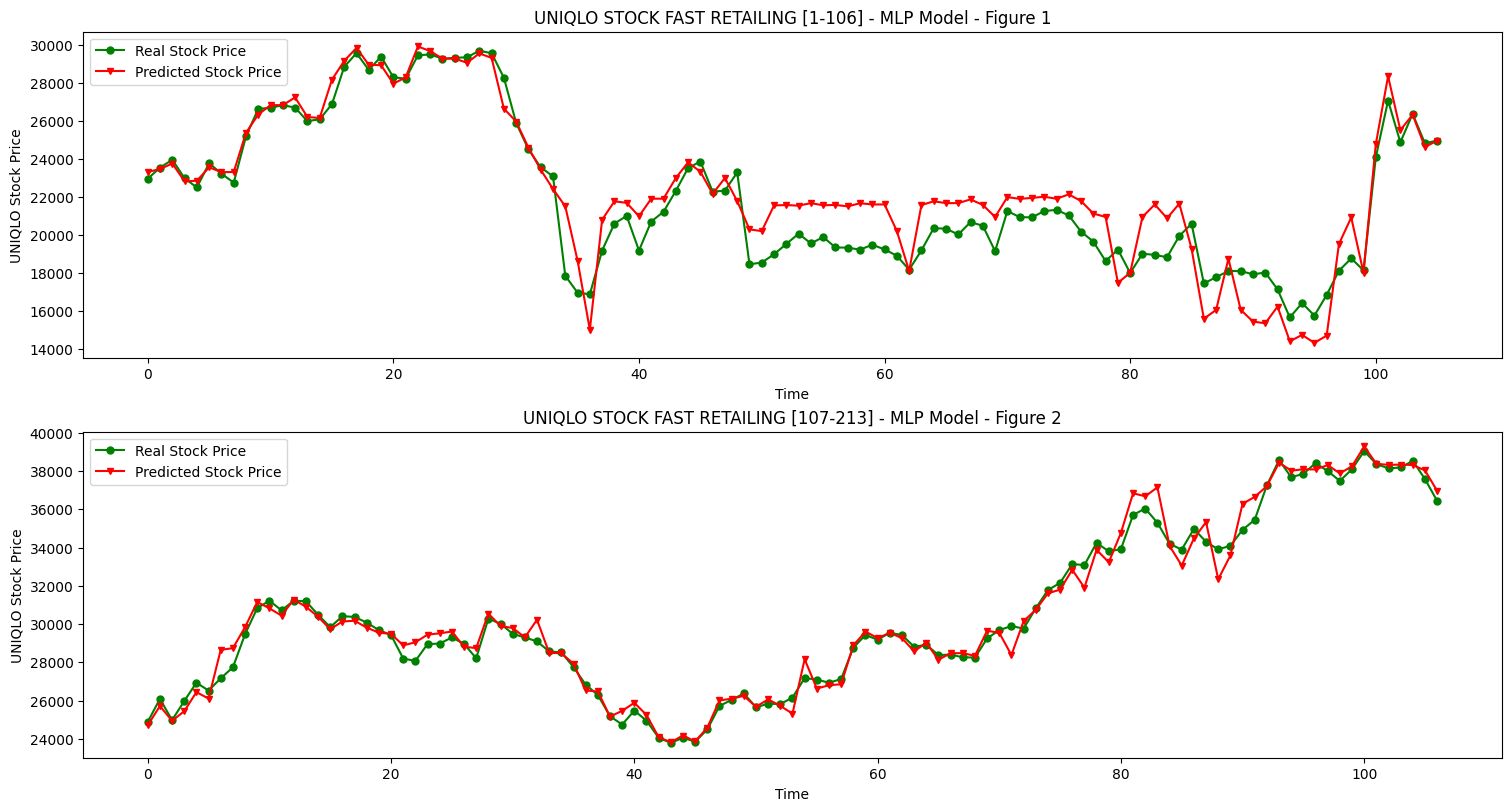

In [ ]:
fig_num = 2
fig, ax = plt.subplots(figsize=[15,4*fig_num], nrows=fig_num, ncols=1, layout='constrained')
test_len = y_pred_knr.shape[0]

for i in range(fig_num):
    start = (test_len // fig_num) * i
    end = (test_len // fig_num) * (i+1) if i != fig_num-1 else test_len
    ax[i].set_title(f'UNIQLO STOCK FAST RETAILING [{start+1}-{end}] - MLP Model - Figure {i+1}')
    ax[i].plot(y_true[start:end], color = 'green', marker='o', markersize=5, label = "Real Stock Price")
    ax[i].plot(y_pred_knr[start:end], color = 'red', marker='v', markersize=5, label = "Predicted Stock Price")
    ax[i].legend()
    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('UNIQLO Stock Price')
fig.savefig('KNR prediction')